In [15]:
import torch
from torch.autograd import grad

def d(f, x):
    return grad(f, x, grad_outputs=torch.ones_like(f), create_graph=True, only_inputs=True)[0]

def EoM(u, x, t, model_params):
    alpha, = model_params
    return d(u, t) - alpha*d(d(u, x), x)

def initial_condition(x, model_params):
    alpha, = model_params
    return torch.exp(-torch.pow(x/0.1, 2)).to(dtype=torch.float, device=x.device).clone().detach()


In [17]:
import torch.nn as nn
from collections import OrderedDict

class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=5, width=100):
        super(Net, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.width = width

        # Input layer to first hidden layer
        self.features = nn.Sequential(
            OrderedDict([
                ('fc0', nn.Linear(in_features=input_dim, out_features=width, bias=True)),
                ('softplus0', nn.Softplus()),
            ])
        )

        # Between hidden layers
        for i in range(hidden_layers - 1):
            self.features.add_module(
                'fc%d' % (i+1), nn.Linear(in_features=width, out_features=width, bias=True)
            )
            self.features.add_module('softplus%d' % (i+1), nn.Softplus())

        # Output layer
        self.features.add_module(
            'fc%d' % hidden_layers,
            nn.Linear(in_features=width, out_features=output_dim, bias=True)
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.features(x)


In [19]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn.functional as F

def train(
    t_start=0.0,
    t_end=0.30,
    x_left=-1.0,
    x_right=1.0,
    model_params=(0.1, ),
    is_load=False,
    epoch=100000,
    n_b=1000,
    n_i=1000,
    n_f=10000,
    EoM_panelty=1.0,
    IC_panelty=10.0,
    BC_panelty=1.0,
    lr=0.001
):
    device = torch.device('mps')
    min_loss = 100.0

    if not is_load:
        model = Net(2, 1, hidden_layers=10, width=20).to(device)
    else:
        model = torch.load('result/PINN.pth', map_location=device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for i in range(epoch):
        optimizer.zero_grad()

        # Inside points
        t_f = ((t_start + t_end) / 2 + (t_end - t_start) * 
               (torch.rand(size=(n_f, 1), dtype=torch.float, device=device) - 0.5)).requires_grad_(True)
        x_f = ((x_left + x_right) / 2 + (x_right - x_left) * 
               (torch.rand(size=(n_f, 1), dtype=torch.float, device=device) - 0.5)).requires_grad_(True)
        u_f = model(torch.cat([x_f, t_f], dim=1))
        EoM_ = EoM(u_f, x_f, t_f, model_params)
        mse_EoM = F.mse_loss(EoM_, torch.zeros_like(EoM_))

        # Boundary conditions
        t_b = ((t_start + t_end) / 2 + (t_end - t_start) * 
               (torch.rand(size=(n_b, 1), dtype=torch.float, device=device) - 0.5)).requires_grad_(True)
        x_b_l = (x_left * torch.ones_like(t_b)).requires_grad_(True)
        x_b_r = (x_right * torch.ones_like(t_b)).requires_grad_(True)
        u_b_l = model(torch.cat([x_b_l, t_b], dim=1))
        u_b_r = model(torch.cat([x_b_r, t_b], dim=1))
        mse_BC = F.mse_loss(u_b_l, u_b_r)

        # Initial condition
        x_i = ((x_left + x_right) / 2 + (x_right - x_left) * 
               (torch.rand(size=(n_i, 1), dtype=torch.float, device=device) - 0.5)).requires_grad_(True)
        t_i = (t_start * torch.ones_like(x_i)).requires_grad_(True)
        u_i = model(torch.cat([x_i, t_i], dim=1))
        u_i_target = initial_condition(x_i, model_params)
        mse_IC = F.mse_loss(u_i, u_i_target)

        # Loss calculation
        loss = EoM_panelty * mse_EoM + IC_panelty * mse_IC + BC_panelty * mse_BC

        if i % 100 == 0:
            print(
                'epoch:{:05d}, EoM: {:.08e}, IC: {:.08e}, BC: {:.08e}, loss: {:.08e}'.format(
                    i, mse_EoM.item(), mse_IC.item(), mse_BC.item(), loss.item()
                )
            )

            if min_loss > loss.item():
                min_loss = loss.item()
                torch.save(model, 'result/PINN.pth')

        loss.backward()
        optimizer.step()


In [2]:
def PINN_show(t_start=0.0, t_end=1, x_left=-1.0, x_right=1.0, n_f=10000):

    # This function samples randomly to show the PINN's predictions
    device = torch.device('mps')
    model = torch.load('result/PINN.pth', map_location=device)

    with torch.no_grad():
        t_f = ((t_start + t_end) / 2 + (t_end - t_start) * 
               (torch.rand(size=(n_f, 1), dtype=torch.float, device=device) - 0.5))
        x_f = ((x_left + x_right) / 2 + (x_right - x_left) * 
               (torch.rand(size=(n_f, 1), dtype=torch.float, device=device) - 0.5))
        u_f = model(torch.cat([x_f, t_f], dim=1))

    print(torch.min(u_f))

    # Saving results to a CSV file
    txu = torch.cat([t_f, x_f, u_f], dim=1).detach().cpu().numpy()
    pd.DataFrame(txu).to_csv('result/txu_PINN.csv', index=False)


In [4]:
def make_grid(
    t_start=0.0, t_end=1, x_left=-1.0, x_right=1.0, time_display_step=100, space_display_step=100
):

    # This function samples on a grid to show the PINN's predictions
    device = torch.device('mps')
    model = torch.load('result/PINN.pth', map_location=device)

    x = np.linspace(x_left, x_right, space_display_step, endpoint=False)
    t = np.linspace(t_start, t_end, time_display_step + 1)

    t_list, x_list = [], []

    # Solving and collecting points on a grid
    for i in range(time_display_step + 1):
        x_d = x.reshape(-1, 1)
        t_d = t[i] * np.ones_like(x_d)
        x_list.append(x_d)
        t_list.append(t_d)

    x_f = torch.tensor(np.concatenate(x_list), dtype=torch.float, device=device)
    t_f = torch.tensor(np.concatenate(t_list), dtype=torch.float, device=device)

    with torch.no_grad():
        u_f = model(torch.cat([x_f, t_f], dim=1))

    print(torch.min(u_f))

    # Saving results to a CSV file
    txu = torch.cat([t_f, x_f, u_f], dim=1).detach().cpu().numpy()
    pd.DataFrame(txu).to_csv('result/txu_PINN.csv', index=False)

In [31]:
import numpy as np
from scipy.sparse import dia_matrix, eye
from scipy.sparse.linalg import spsolve
import pandas as pd

def Dxx(n):
    offsets = np.array([0, -1, 1, n - 1, 1 - n])
    data = np.array([-2*np.ones(n), np.ones(n), np.ones(n), np.ones(n), np.ones(n)])
    return dia_matrix((data, offsets), shape=(n, n))

if __name__ == "__main__":
    x_left = -1.0
    x_right = 1.0
    t_start = 0.0
    t_end = 1

    time_display_step = 100
    space_display_step = 100

    alpha = 0.1
    n = 100

    space_cal_step = space_display_step * n
    time_cal_step = time_display_step * n

    idx_display = np.arange(0, space_cal_step, n)
    dx = (x_right - x_left) / space_cal_step
    dt = (t_end - t_start) / time_cal_step

    x = np.linspace(x_left, x_right, space_cal_step, endpoint=False)
    t = np.linspace(t_start, t_end, time_cal_step + 1)
    u = np.empty(shape=(time_cal_step + 1, space_cal_step))

    ep = alpha * dt / (dx * dx * 2)
    dxx = Dxx(space_cal_step)
    identity = eye(space_cal_step)
    A_l = identity - ep * dxx
    A_r = identity + ep * dxx

    # Initialization
    u[0, :] = np.exp(-np.power(x / 0.1, 2))

    display_points = []

    # Solving
    for i in range(0, time_cal_step - 1):
        u[i + 1, :] = spsolve(A=A_l, b=A_r.dot(u[i, :]))

        if i % n == 0:
            print(t[i])

            u_d = u[i, idx_display].reshape(-1, 1)
            x_d = x[idx_display].reshape(-1, 1)
            t_d = t[i] * np.ones_like(x_d)

            display_points.append(np.concatenate([t_d, x_d, u_d], axis=1))

    display_points = np.concatenate(display_points)
    pd.DataFrame(display_points).to_csv('./result/txu_NUMERICAL.csv', index=False)


0.0
0.01
0.02
0.030000000000000002
0.04
0.05
0.060000000000000005
0.07
0.08
0.09000000000000001
0.1
0.11
0.12000000000000001
0.13
0.14
0.15
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49000000000000005
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.5900000000000001
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.7200000000000001
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.8500000000000001
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.9700000000000001
0.9800000000000001
0.9900000000000001


In [32]:
def L2_difference():

    # This function computes the L2 loss between the numerical solution and PINN's solution
    device = torch.device('mps')
    model = torch.load('result/PINN.pth', map_location=device)

    data = pd.read_csv('result/txu_NUMERICAL.csv').values

    t_f = torch.tensor(data[:, 0].reshape(-1, 1), dtype=torch.float, device=device)
    x_f = torch.tensor(data[:, 1].reshape(-1, 1), dtype=torch.float, device=device)
    u_n = torch.tensor(data[:, 2].reshape(-1, 1), dtype=torch.float, device=device)

    with torch.no_grad():
        u_f = model(torch.cat([x_f, t_f], dim=1))

    return F.mse_loss(u_n, u_f).item()


In [17]:
train()


epoch:00000, EoM: 7.78761062e-13, IC: 5.90661205e-02, BC: 3.32835842e-11, loss: 5.90661228e-01
epoch:00100, EoM: 6.21542965e-13, IC: 5.52148782e-02, BC: 1.15428474e-11, loss: 5.52148759e-01
epoch:00200, EoM: 1.18513175e-12, IC: 4.67280149e-02, BC: 1.20927218e-11, loss: 4.67280149e-01
epoch:00300, EoM: 3.84744710e-12, IC: 5.87131195e-02, BC: 2.87036055e-11, loss: 5.87131202e-01
epoch:00400, EoM: 3.77727190e-11, IC: 5.22298366e-02, BC: 5.02360598e-10, loss: 5.22298336e-01
epoch:00500, EoM: 6.93211769e-05, IC: 5.65843321e-02, BC: 1.81931956e-03, loss: 5.67731977e-01
epoch:00600, EoM: 4.19589691e-02, IC: 3.09055652e-02, BC: 2.35266361e-05, loss: 3.51038128e-01
epoch:00700, EoM: 4.14884724e-02, IC: 2.55199745e-02, BC: 3.09319003e-04, loss: 2.96997517e-01
epoch:00800, EoM: 3.61529589e-02, IC: 2.28930134e-02, BC: 1.42527133e-04, loss: 2.65225589e-01
epoch:00900, EoM: 3.85897234e-02, IC: 1.55506711e-02, BC: 1.05088089e-04, loss: 1.94201529e-01
epoch:01000, EoM: 3.28223817e-02, IC: 1.22930249e-

In [33]:
PINN_show()

tensor(-5.0433e-05, device='mps:0')


In [34]:
make_grid()

tensor(-5.1878e-05, device='mps:0')


In [35]:
diff = L2_difference()
print(f"L2 loss is {diff:.10e}")

L2 loss is 8.4847713879e-05


In [36]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Load numerical and PINN solutions from CSV files
def load_numerical_solution(file_path):
    data = pd.read_csv(file_path).values
    return data[:, 0], data[:, 1], data[:, 2]  # t, x, u_n

def load_pinn_solution(file_path):
    data = pd.read_csv(file_path).values
    return data[:, 0], data[:, 1], data[:, 2]  # t, x, u_pinn

# Plot combined 3D scatter plot
def plot_combined_3d(t_n, x_n, u_n, t_pinn, x_pinn, u_pinn):
    # Create figure
    fig = go.Figure()

    # Add numerical solution
    fig.add_trace(go.Scatter3d(
        x=t_n, 
        y=x_n, 
        z=u_n, 
        mode='markers',
        marker=dict(size=2, color='blue', opacity=0.8),
        name='Numerical Solution',
    ))

    # Add PINN solution
    fig.add_trace(go.Scatter3d(
        x=t_pinn, 
        y=x_pinn, 
        z=u_pinn, 
        mode='markers',
        marker=dict(size=2, color='red', opacity=0.8),
        name='PINN Solution',
    ))

    # Update layout
    fig.update_layout(
        title='Comparison of Numerical and PINN Solutions',
        scene=dict(
            xaxis_title='Time',
            yaxis_title='Space',
            zaxis_title='u',
            aspectmode='cube'
        ),
        showlegend=True
    )

    # Show plot
    fig.show()

# Load solutions
t_n, x_n, u_n = load_numerical_solution('./result/txu_NUMERICAL.csv')
t_pinn, x_pinn, u_pinn = load_pinn_solution('./result/txu_PINN.csv')

# Plot combined 3D visualization
plot_combined_3d(t_n, x_n, u_n, t_pinn, x_pinn, u_pinn)


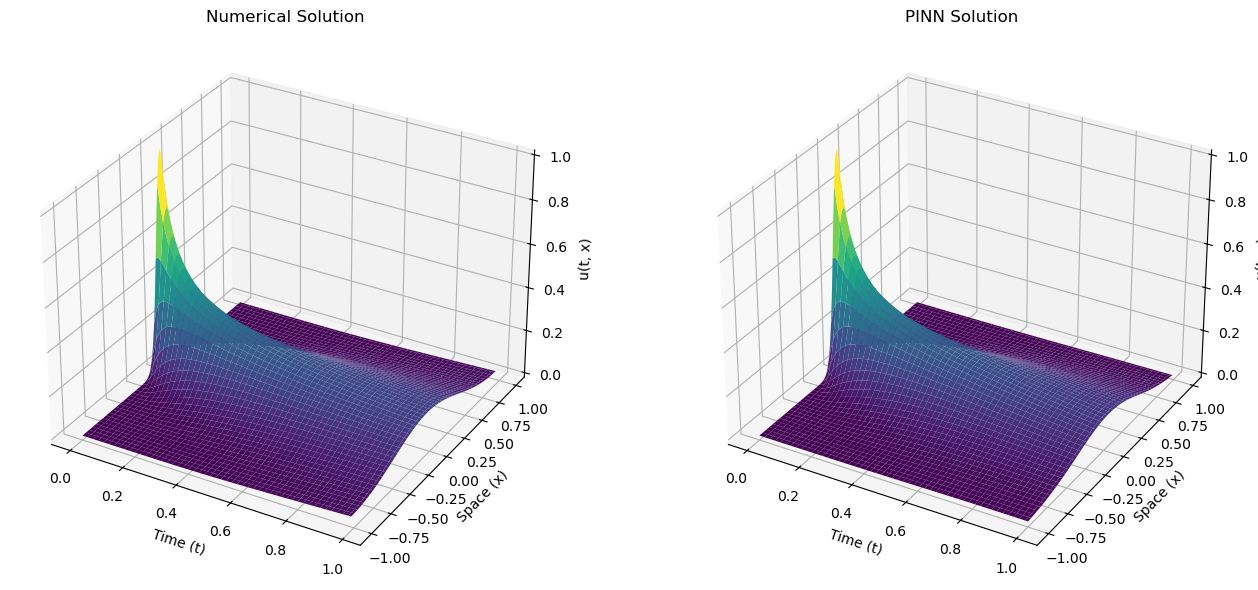

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_solutions_side_by_side(t_n, x_n, u_n, t_pinn, x_pinn, u_pinn):
    # Create a figure with two subplots
    fig = plt.figure(figsize=(14, 6))

    # Subplot for the Numerical Solution
    ax1 = fig.add_subplot(121, projection='3d')
    grid_t_n, grid_x_n = np.meshgrid(
        np.linspace(np.min(t_n), np.max(t_n), 100),
        np.linspace(np.min(x_n), np.max(x_n), 100)
    )
    grid_u_n = griddata((t_n.flatten(), x_n.flatten()), u_n.flatten(), (grid_t_n, grid_x_n), method='cubic')
    ax1.plot_surface(grid_t_n, grid_x_n, grid_u_n, cmap='viridis', edgecolor='none')
    ax1.set_title('Numerical Solution')
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('Space (x)')
    ax1.set_zlabel('u(t, x)')

    # Subplot for the PINN Solution
    ax2 = fig.add_subplot(122, projection='3d')
    grid_t_pinn, grid_x_pinn = np.meshgrid(
        np.linspace(np.min(t_pinn), np.max(t_pinn), 100),
        np.linspace(np.min(x_pinn), np.max(x_pinn), 100)
    )
    grid_u_pinn = griddata((t_pinn.flatten(), x_pinn.flatten()), u_pinn.flatten(), (grid_t_pinn, grid_x_pinn), method='cubic')
    ax2.plot_surface(grid_t_pinn, grid_x_pinn, grid_u_pinn, cmap='viridis', edgecolor='none')
    ax2.set_title('PINN Solution')
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Space (x)')
    ax2.set_zlabel('u(t, x)')

    plt.tight_layout()
    plt.show()
data_numerical = pd.read_csv('./result/txu_NUMERICAL.csv').values
t_n = data_numerical[:, 0].reshape(-1, 1)
x_n = data_numerical[:, 1].reshape(-1, 1)
u_n = data_numerical[:, 2].reshape(-1, 1)

# Load the PINN solution from the CSV file
data_pinn = pd.read_csv('./result/txu_PINN.csv').values
t_pinn = data_pinn[:, 0].reshape(-1, 1)
x_pinn = data_pinn[:, 1].reshape(-1, 1)
u_pinn = data_pinn[:, 2].reshape(-1, 1)

# Plot both solutions side by side
plot_solutions_side_by_side(t_n, x_n, u_n, t_pinn, x_pinn, u_pinn)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_error_3d(t_n, x_n, u_n, t_pinn, x_pinn, u_pinn):
    # Calculate the absolute error
    error = np.abs(u_n - u_pinn)

    # Create a 3D plot for the error
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Generate a grid for the error surface
    grid_t, grid_x = np.meshgrid(
        np.linspace(np.min(t_n), np.max(t_n), 100),
        np.linspace(np.min(x_n), np.max(x_n), 100)
    )
    
    grid_error = griddata((t_n.flatten(), x_n.flatten()), error.flatten(), (grid_t, grid_x), method='cubic')

    # Plot the error surface
    surf = ax.plot_surface(grid_t, grid_x, grid_error, cmap='plasma', edgecolor='none')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    ax.set_title('Absolute Error between Numerical and PINN Solutions')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Space (x)')
    ax.set_zlabel('Absolute Error')

    plt.show()


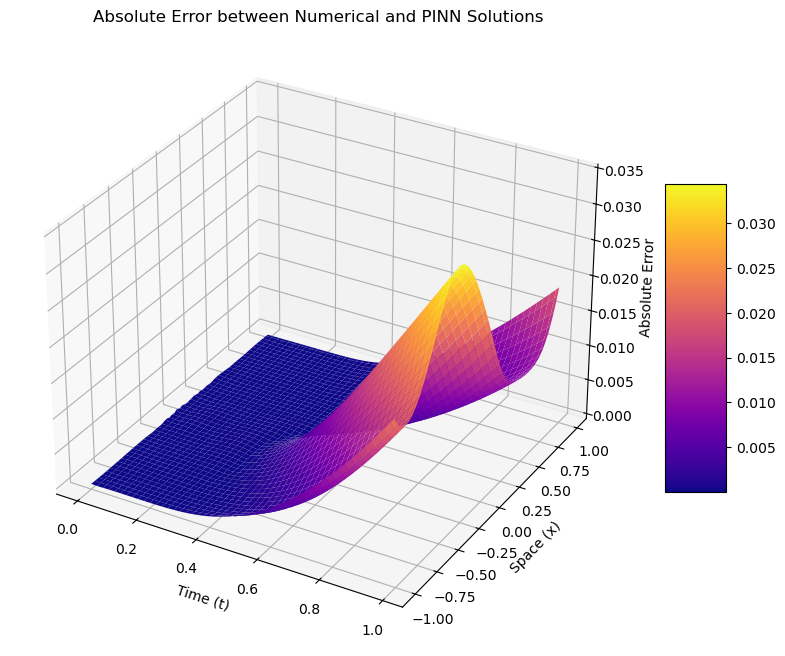

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def load_data_and_interpolate(numerical_file, pinn_file):
    # Load the numerical solution from CSV
    data_numerical = pd.read_csv(numerical_file).values
    t_n = data_numerical[:, 0].reshape(-1, 1)
    x_n = data_numerical[:, 1].reshape(-1, 1)
    u_n = data_numerical[:, 2].reshape(-1, 1)

    # Load the PINN solution from CSV
    data_pinn = pd.read_csv(pinn_file).values
    t_pinn = data_pinn[:, 0].reshape(-1, 1)
    x_pinn = data_pinn[:, 1].reshape(-1, 1)
    u_pinn = data_pinn[:, 2].reshape(-1, 1)

    # Interpolate PINN data to match the numerical grid
    u_pinn_interp = griddata(
        (t_pinn.flatten(), x_pinn.flatten()), 
        u_pinn.flatten(), 
        (t_n.flatten(), x_n.flatten()), 
        method='cubic'
    ).reshape(u_n.shape)

    return t_n, x_n, u_n, t_pinn, x_pinn, u_pinn_interp

def plot_error_3d(t_n, x_n, u_n, u_pinn):
    # Calculate the absolute error
    error = np.abs(u_n - u_pinn)

    # Create a 3D plot for the error
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Generate a grid for the error surface
    grid_t, grid_x = np.meshgrid(
        np.linspace(np.min(t_n), np.max(t_n), 100),
        np.linspace(np.min(x_n), np.max(x_n), 100)
    )
    
    grid_error = griddata((t_n.flatten(), x_n.flatten()), error.flatten(), (grid_t, grid_x), method='cubic')

    # Plot the error surface
    surf = ax.plot_surface(grid_t, grid_x, grid_error, cmap='plasma', edgecolor='none')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    ax.set_title('Absolute Error between Numerical and PINN Solutions')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Space (x)')
    ax.set_zlabel('Absolute Error')

    plt.show()

if __name__ == "__main__":
    # Load and interpolate data
    t_n, x_n, u_n, t_pinn, x_pinn, u_pinn = load_data_and_interpolate('./result/txu_NUMERICAL.csv', './result/txu_PINN.csv')

    # Plot the error
    plot_error_3d(t_n, x_n, u_n, u_pinn)
